Asset disponibili di default: ['SPY', 'TLT', 'AAPL', 'GOOG', 'GLD', 'MSFT', 'AMZN', 'BTC-USD']
Inserisci una lista di ticker separati da virgola (invio = default):

Data inizio (YYYY-MM-DD) [default: 2015-01-01]: 2005-01-01
Data fine (YYYY-MM-DD, 'oggi' per oggi) [default: oggi]: 
Capitale iniziale (EUR) [default: 10000]: 100000

Scarico dati da 2005-01-01 a 2025-06-26 per gli asset: ['SPY', 'TLT', 'AAPL', 'GOOG', 'GLD', 'MSFT', 'AMZN', 'BTC-USD']


/tmp/ipython-input-6-1995790722.py:51: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_raw = yf.download(assets, start=start, end=end, progress=True, threads=True)
[*********************100%***********************]  8 of 8 completed


Formato dati non previsto, uso il 'Close'.

Asset effettivamente scaricati e utilizzati: ['AAPL', 'AMZN', 'BTC-USD', 'GLD', 'GOOG', 'MSFT', 'SPY', 'TLT']

Calcolo il portafoglio ottimale (massimo Sharpe)...
Expected annual return: 23.8%
Annual volatility: 17.0%
Sharpe Ratio: 1.40


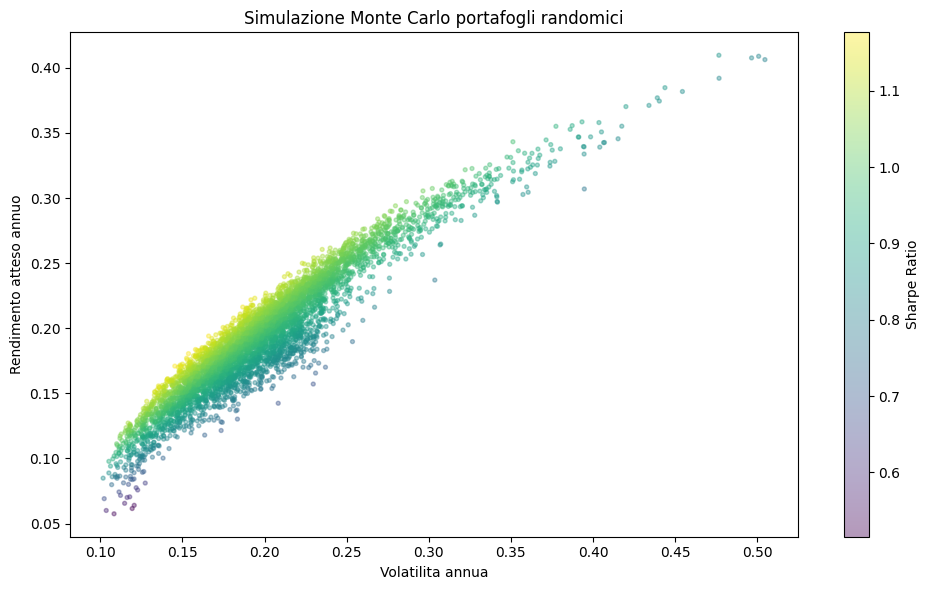


Composizione portafoglio ottimale (Sharpe Max):
AAPL: 4.68%
AMZN: 8.13%
BTC-USD: 13.71%
GLD: 46.46%
GOOG: 0.00%
MSFT: 27.02%
SPY: 0.00%
TLT: 0.00%

Risultati attesi sul portafoglio ottimizzato:
- Rendimento annuo atteso: 23.82%
- Volatilita annua attesa: 16.97%
- Sharpe ratio atteso: 1.40

Come leggere questi risultati:

1. Composizione Portafoglio: Mostra la percentuale da investire su ciascun asset, scelta per massimizzare il rapporto rendimento/rischio (Sharpe).
2. Rendimento Atteso: Quanta crescita annuale media ci si aspetta dal portafoglio secondo i dati storici.
3. Volatilita Attesa: Oscillazione media annuale, cioe quanto il portafoglio puo variare di valore.
4. Sharpe Ratio: Indice di efficienza rischio/rendimento. Valori sopra 1 sono considerati buoni, sopra 2 eccellenti.
5. Grafico Monte Carlo: Ogni punto e un portafoglio casuale. Il colore indica lo Sharpe Ratio. Il portafoglio ottimale si trova nel punto piu efficiente.
6. Capitale Finale Simulato: Simula il valore del ca

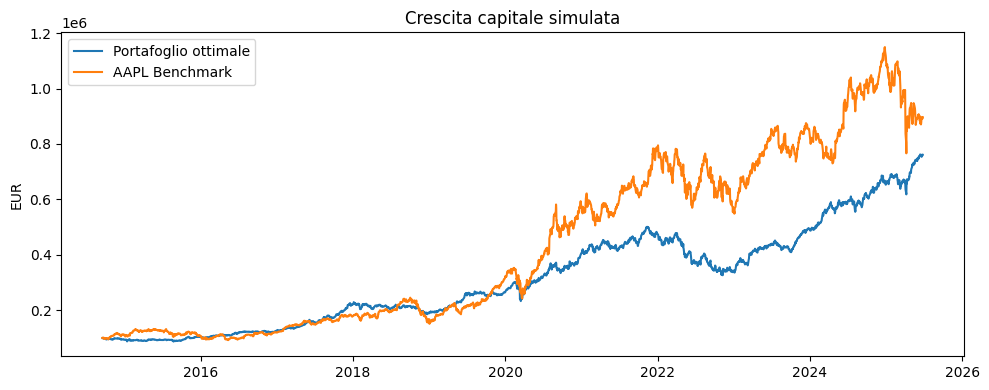

/tmp/ipython-input-6-1995790722.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\nCapitale finale simulato investendo nel portafoglio ottimale: {cumulative[-1]:.2f} EUR")



Capitale finale simulato investendo nel portafoglio ottimale: 761249.54 EUR

Grazie per aver usato il simulatore!

Report PDF creato! Scaricalo da Colab con il pulsante 'File' oppure esegui questa cella per scaricarlo direttamente:


/tmp/ipython-input-6-1995790722.py:190: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pdf.cell(0, 10, f"Capitale finale simulato: {cumulative[-1]:.2f} EUR", ln=1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# STEP 0: Installa librerie (esegui solo la prima volta)
!pip install yfinance pandas numpy matplotlib PyPortfolioOpt fpdf

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns
from datetime import datetime
from fpdf import FPDF

# Funzione input robusto
def user_input(prompt, default=None, validator=None):
    while True:
        val = input(f"{prompt} [default: {default}]: ") or default
        if validator:
            try:
                if validator(val):
                    return val
            except Exception:
                print("Input non valido. Riprova.")
        else:
            return val

# 1. INPUT UTENTE
default_assets = ['SPY', 'TLT', 'AAPL', 'GOOG', 'GLD', 'MSFT', 'AMZN', 'BTC-USD']
print("Asset disponibili di default:", default_assets)
assets = input("Inserisci una lista di ticker separati da virgola (invio = default):\n") or ",".join(default_assets)
assets = [x.strip().upper() for x in assets.split(",")]

def validate_date(x):
    if x.lower() in ["oggi", "today", ""]:
        return True
    datetime.strptime(x, "%Y-%m-%d")
    return True

start = user_input("Data inizio (YYYY-MM-DD)", "2015-01-01", validator=validate_date)
end = user_input("Data fine (YYYY-MM-DD, 'oggi' per oggi)", "oggi", validator=validate_date)
if end.lower() in ["oggi", "today", ""]:
    end = pd.Timestamp.today().strftime("%Y-%m-%d")
if start.lower() in ["oggi", "today", ""]:
    start = pd.Timestamp.today().strftime("%Y-%m-%d")
try:
    initial_capital = float(user_input("Capitale iniziale (EUR)", "10000", validator=lambda x: float(x)>0))
except:
    initial_capital = 10000

print(f"\nScarico dati da {start} a {end} per gli asset: {assets}")

# 2. DOWNLOAD DATI & VALIDAZIONE
data_raw = yf.download(assets, start=start, end=end, progress=True, threads=True)
if 'Adj Close' in data_raw.columns:
    data = data_raw['Adj Close']
elif isinstance(data_raw.columns, pd.MultiIndex) and 'Adj Close' in data_raw.columns.get_level_values(0):
    data = data_raw['Adj Close']
else:
    print("Formato dati non previsto, uso il 'Close'.")
    data = data_raw['Close'] if 'Close' in data_raw.columns else data_raw

data = data.dropna(axis=1, how='all').dropna()
assets_clean = list(data.columns)
if len(assets_clean) < 2:
    print("\nErrore: Nessun asset o solo uno scaricato correttamente!")
    print("Possibili cause:")
    print("- Ticker sbagliato (es. APPL invece di AAPL)")
    print("- Date troppo restrittive (prova un intervallo piu ampio)")
    print("- Asset non piu disponibili")
    print("Rilancia il codice con altri asset o un altro periodo.")
    import sys; sys.exit()

print("\nAsset effettivamente scaricati e utilizzati:", assets_clean)
returns = np.log(data / data.shift(1)).dropna()

# 3. PORTFOLIO OPTIMIZER (Markowitz)
print("\nCalcolo il portafoglio ottimale (massimo Sharpe)...")
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
performance = ef.portfolio_performance(verbose=True)

# 4. SIMULAZIONE MONTE CARLO (solo asset presenti)
n_assets = len(assets_clean)
n_portfolios = 5000
all_weights = np.zeros((n_portfolios, n_assets))
ret_arr = np.zeros(n_portfolios)
vol_arr = np.zeros(n_portfolios)
sharpe_arr = np.zeros(n_portfolios)

for i in range(n_portfolios):
    w = np.random.dirichlet(np.ones(n_assets))
    all_weights[i,:] = w
    port_return = np.sum(returns.mean() * w) * 252
    port_vol = np.sqrt(np.dot(w.T, np.dot(returns.cov() * 252, w)))
    ret_arr[i] = port_return
    vol_arr[i] = port_vol
    sharpe_arr[i] = port_return/port_vol

plt.figure(figsize=(10,6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', marker='o', s=8, alpha=0.4)
plt.xlabel("Volatilita annua")
plt.ylabel("Rendimento atteso annuo")
plt.colorbar(label='Sharpe Ratio')
plt.title("Simulazione Monte Carlo portafogli randomici")
plt.tight_layout()
plt.savefig("montecarlo.png")
plt.show()

# 5. REPORT RISULTATI CON SPIEGAZIONE DETTAGLIATA
print("\nComposizione portafoglio ottimale (Sharpe Max):")
for asset, weight in cleaned_weights.items():
    print(f"{asset}: {weight:.2%}")

print(f"\nRisultati attesi sul portafoglio ottimizzato:")
print(f"- Rendimento annuo atteso: {performance[0]:.2%}")
print(f"- Volatilita annua attesa: {performance[1]:.2%}")
print(f"- Sharpe ratio atteso: {performance[2]:.2f}")

print("\nCome leggere questi risultati:")
print("""
1. Composizione Portafoglio: Mostra la percentuale da investire su ciascun asset, scelta per massimizzare il rapporto rendimento/rischio (Sharpe).
2. Rendimento Atteso: Quanta crescita annuale media ci si aspetta dal portafoglio secondo i dati storici.
3. Volatilita Attesa: Oscillazione media annuale, cioe quanto il portafoglio puo variare di valore.
4. Sharpe Ratio: Indice di efficienza rischio/rendimento. Valori sopra 1 sono considerati buoni, sopra 2 eccellenti.
5. Grafico Monte Carlo: Ogni punto e un portafoglio casuale. Il colore indica lo Sharpe Ratio. Il portafoglio ottimale si trova nel punto piu efficiente.
6. Capitale Finale Simulato: Simula il valore del capitale investendo nel portafoglio ottimale per tutto il periodo selezionato.
""")

# 6. SIMULAZIONE CRESCITA CAPITALE + GRAFICO
portfolio_daily_returns = returns.dot(np.array(list(cleaned_weights.values())))
cumulative = (1 + portfolio_daily_returns).cumprod() * initial_capital
plt.figure(figsize=(10,4))
plt.plot(cumulative, label="Portafoglio ottimale")
plt.plot((data[assets_clean[0]]/data[assets_clean[0]].iloc[0])*initial_capital, label=assets_clean[0]+" Benchmark")
plt.legend()
plt.title("Crescita capitale simulata")
plt.ylabel("EUR")
plt.tight_layout()
plt.savefig("performance.png")
plt.show()

print(f"\nCapitale finale simulato investendo nel portafoglio ottimale: {cumulative[-1]:.2f} EUR")
print("\nGrazie per aver usato il simulatore!")

# 7. ESPORTA REPORT IN PDF (solo caratteri semplici!)
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", 'B', 16)
pdf.cell(0, 12, "Report Simulazione Portafoglio Finanziario", ln=1, align="C")
pdf.set_font("Arial", '', 12)
pdf.ln(3)
pdf.multi_cell(0, 8, f"Periodo analizzato: {start} - {end}\nAsset analizzati: {', '.join(assets_clean)}")
pdf.ln(2)
pdf.set_font("Arial", 'B', 12)
pdf.cell(0, 10, "Composizione Portafoglio Ottimale:", ln=1)
pdf.set_font("Arial", '', 12)
for asset, weight in cleaned_weights.items():
    pdf.cell(0, 8, f"{asset}: {weight:.2%}", ln=1)

pdf.ln(3)
pdf.cell(0, 10, "Risultati attesi:", ln=1)
pdf.set_font("Arial", '', 12)
pdf.cell(0, 8, f"Rendimento annuo atteso: {performance[0]:.2%}", ln=1)
pdf.cell(0, 8, f"Volatilita annua attesa: {performance[1]:.2%}", ln=1)
pdf.cell(0, 8, f"Sharpe ratio atteso: {performance[2]:.2f}", ln=1)
pdf.ln(4)
pdf.set_font("Arial", '', 11)
pdf.multi_cell(0, 7, "Cosa e lo Sharpe Ratio? E un indice che misura quanto rendimento ottieni rispetto al rischio: piu e alto, meglio stai usando il rischio per ottenere ritorni.")

pdf.ln(3)
pdf.set_font("Arial", 'B', 12)
pdf.cell(0, 10, "Interpretazione dei Risultati:", ln=1)
pdf.set_font("Arial", '', 11)
pdf.multi_cell(0, 8, """
- Un portafoglio bilanciato aiuta a ridurre il rischio rispetto all'investimento in un solo asset.
- Un alto Sharpe Ratio indica una combinazione molto efficiente rischio/rendimento.
- Il grafico Monte Carlo mostra la posizione del portafoglio ottimale rispetto a migliaia di combinazioni casuali.
- Il grafico crescita capitale mostra quanto sarebbe cresciuto il capitale investendo nel portafoglio ottimale rispetto a un singolo asset benchmark.
""")

pdf.ln(3)
pdf.set_font("Arial", 'B', 12)
pdf.cell(0, 10, "Grafici:", ln=1)
pdf.image("montecarlo.png", x=10, w=pdf.w - 20)
pdf.ln(4)
pdf.image("performance.png", x=10, w=pdf.w - 20)
pdf.ln(4)
pdf.set_font("Arial", '', 12)
pdf.cell(0, 10, f"Capitale finale simulato: {cumulative[-1]:.2f} EUR", ln=1)

pdf.output("Report_Portafoglio.pdf")
print("\nReport PDF creato! Scaricalo da Colab con il pulsante 'File' oppure esegui questa cella per scaricarlo direttamente:")

from google.colab import files
files.download("Report_Portafoglio.pdf")